# Deep Crossentropy method

In this section we'll extend your CEM (Cross-Entropy Method) implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [2]:
from google.colab import drive 
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


state vector dim = 4
n_actions = 2


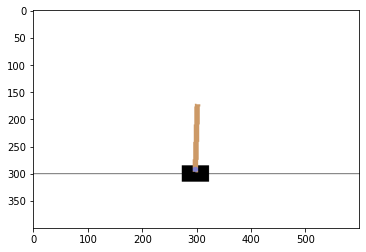

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [4]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [5]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0
    n_actions = env.action_space.n
    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        # probs =  <YOUR CODE>
        probs = agent.predict_proba([s]).reshape(n_actions,)

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        # a = <YOUR CODE>
        a = np.random.choice(np.arange(n_actions), p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [ ]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.00530705 -0.03271175  0.02343056 -0.00559593]
 [-0.00596128  0.16206648  0.02331864 -0.29079512]
 [-0.00271995 -0.03338008  0.01750274  0.00915007]
 [-0.00338755 -0.22874861  0.01768574  0.30730353]
 [-0.00796253 -0.42411805  0.02383181  0.60551119]]
actions: [1, 0, 0, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [6]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards > percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    # <YOUR CODE: copy-paste your implementation from the previous notebook>
    reward_threshold = np.percentile(rewards_batch, percentile)
    elites_sessions_mask = np.array(rewards_batch) > reward_threshold

    elite_states = np.array(states_batch)[elites_sessions_mask]
    elite_actions = np.array(actions_batch)[elites_sessions_mask]
    elite_states = [x for sublist in elite_states for x in sublist]
    elite_actions = [x for sublist in elite_actions for x in sublist]

    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [7]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 204.500, threshold=233.000


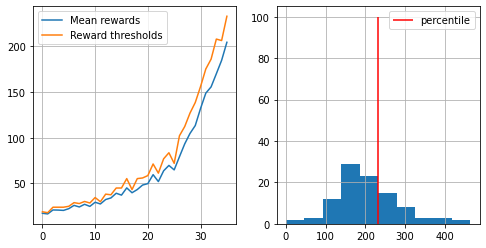

You Win!
CPU times: user 1min 7s, sys: 1.89 s, total: 1min 9s
Wall time: 1min 7s


In [ ]:
%%time
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    # sessions = [ <YOUR CODE: generate a list of n_sessions new sessions> ]
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    # elite_states, elite_actions = <YOUR CODE: select elite actions just like before>
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    # <YOUR CODE: partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, elite_actions, range(n_actions))

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win!")
        break

# Results

In [ ]:
%%time
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(200)]

CPU times: user 17.5 s, sys: 687 ms, total: 18.2 s
Wall time: 21.9 s


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here>```

---
0. Made training_loop() function to re-run training with different parameters and add early stopping when positive score is reached.
1. I've tried different hyperparameters combinations making
* n_sessions: 250 -> 500 (more)
* percentile: 50 -> 30 (lower)
* learning_rate: 0.5 -> 0.3 (lower)
2. Increasing only n_sessions gives us the similar results as in baseline configuration: more observations but threshold is the same, we throw away a lot of "upsuccessfull" (but possibly usefull) scenarios.
3. Decreasing only percentile gives different results from launch to launch, and even sometimes converged succesfully; probably sometimes not enough good initial samples and then we're walking around them.
4. Combining both approaches above (and following duct tape way), we keep more "upsuccessfull" scenarios from a good sized batch of samples and it helps to find the proper way for even rare starting points of passenger and driver.
5. Decreasing learning_rate gives us slower convergence, we don't trust so much to every new policy update, and it leads us to the same positive result.
---

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent CEM training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [8]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

## Solving MountainCar

In [ ]:
from IPython import display

TIME_LIMIT = 10**4
env = gym.wrappers.TimeLimit(
    gym.envs.classic_control.MountainCarEnv(),
    max_episode_steps=TIME_LIMIT + 1,
)

n_states=2, n_actions=3


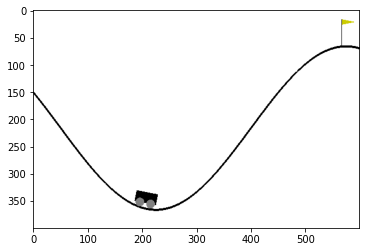

In [ ]:
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
print("n_states=%i, n_actions=%i" % (n_states, n_actions))

env.reset()
plt.imshow(env.render("rgb_array"))
plt.show()

In [ ]:
# more neurons and gradually decreasing learning_rate
agent = MLPClassifier(
    hidden_layer_sizes=(40, 40),
    activation='tanh',
    learning_rate='invscaling'
)
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(40, 40),
              learning_rate='invscaling')

mean reward = -95.200, threshold=-85.000


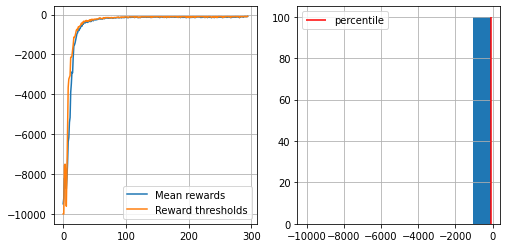

 98%|█████████▊| 294/300 [1:24:34<01:43, 17.26s/it]

You Win!
CPU times: user 12min 12s, sys: 2min 28s, total: 14min 41s
Wall time: 1h 24min 34s


In [ ]:
%%time
from tqdm import tqdm
from collections import deque
from joblib import Parallel, delayed

n_sessions = 100
percentile = 70
T_MAX = 10**4
log = []

# let's keep last 5 iterations for re-use good sessions for threshold and training
states_buffer = deque(maxlen=5)
actions_buffer = deque(maxlen=5)
rewards_buffer = deque(maxlen=5)

for i in tqdm(range(300)):
    # parallel sessions generation
    delayed_session = delayed(generate_session)(
        gym.wrappers.TimeLimit(
            gym.envs.classic_control.MountainCarEnv(),
            max_episode_steps=TIME_LIMIT + 1), 
        agent, 
        t_max=T_MAX
    )
    sessions = Parallel(n_jobs=2)(delayed_session for _ in range(n_sessions))
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    # when buffer's len exceeded it pops the oldest session's result
    states_buffer.append(states_batch)
    actions_buffer.append(actions_batch)
    rewards_buffer.append(rewards_batch)

    elite_states, elite_actions = select_elites(list(states_buffer), 
                                                list(actions_buffer), 
                                                list(rewards_buffer), 
                                                percentile)
    
    # make fit only if elites are found, otherwise skip this iteration and continue generate sessions
    # (could be essential at the very beginning)
    if len(elite_states) > 0:
      agent.partial_fit(elite_states, elite_actions, range(n_actions))

    show_progress(rewards_batch, log, percentile, reward_range=[-T_MAX, np.max(rewards_batch)])

    # Trying to reach a higher score
    if np.mean(rewards_batch) > -100:
        print("You Win!")
        break

### Saving agent into file (just in case)

In [ ]:
import pickle

with open('/drive/MyDrive/Colab Notebooks/RL/agent_MountainCar-100.pkl', 'wb') as f:
    pickle.dump(agent, f, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/drive/MyDrive/Colab Notebooks/RL/agent_MountainCar-100.pkl', 'rb') as f:
#     agent = pickle.load(f)

### Visualize car's learning

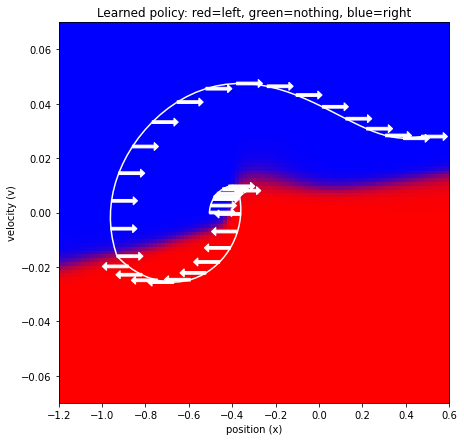

In [ ]:
with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent)

### Visualize agent

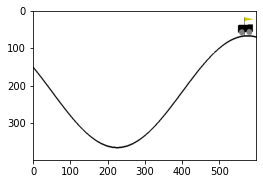

In [ ]:
plt.figure(figsize=(4, 3))
display.clear_output(wait=True)

obs = env.reset()
for t in range(TIME_LIMIT):
    plt.gca().clear()
    
    probs = agent.predict_proba([obs]).reshape(n_actions,)
    action = np.random.choice(np.arange(n_actions), p=probs)
    new_obs, reward, done, _ = env.step(action)
    obs = new_obs

    plt.imshow(env.render('rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

display.clear_output(wait=True)

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.

---

## Solving LunarLander (with the same network architecture and training params)

In [ ]:
# !pip3 install box2d-py
# !pip3 install gym[Box_2D]
import gym
env = gym.make("LunarLander-v2")

n_states=8, n_actions=4


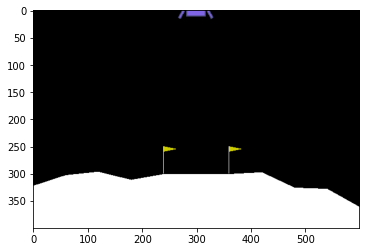

In [ ]:
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
print("n_states=%i, n_actions=%i" % (n_states, n_actions))

env.reset()
plt.imshow(env.render("rgb_array"))
plt.show()

In [ ]:
# same architecture as in MountainCar
agent = MLPClassifier(
    hidden_layer_sizes=(40, 40),
    activation='tanh',
    learning_rate='invscaling'
)
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(40, 40),
              learning_rate='invscaling')

mean reward = 53.850, threshold=50.232


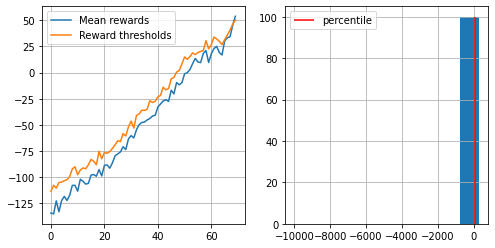

 23%|██▎       | 69/300 [07:18<24:27,  6.35s/it]  

You Win!
CPU times: user 1min 28s, sys: 17.8 s, total: 1min 46s
Wall time: 7min 18s


In [ ]:
%%time
from tqdm import tqdm
from collections import deque
from joblib import Parallel, delayed

# same params as in MountainCar
n_sessions = 100
percentile = 70
T_MAX = 10**4
log = []

states_buffer = deque(maxlen=5)
actions_buffer = deque(maxlen=5)
rewards_buffer = deque(maxlen=5)

for i in tqdm(range(300)):
    delayed_session = delayed(generate_session)(
        gym.make("LunarLander-v2"),
        agent, 
        t_max=T_MAX
    )
    sessions = Parallel(n_jobs=2)(delayed_session for _ in range(n_sessions))
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    states_buffer.append(states_batch)
    actions_buffer.append(actions_batch)
    rewards_buffer.append(rewards_batch)

    elite_states, elite_actions = select_elites(states_buffer, 
                                                actions_buffer, 
                                                rewards_buffer, 
                                                percentile)
    if len(elite_states) > 0:
      agent.partial_fit(elite_states, elite_actions, range(n_actions))

    show_progress(rewards_batch, log, percentile, reward_range=[-T_MAX, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 50:
        print("You Win!")
        break

In [ ]:
import pickle

with open('/drive/MyDrive/Colab Notebooks/RL/agent_LunarLander+50.pkl', 'wb') as f:
    pickle.dump(agent, f, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/drive/MyDrive/Colab Notebooks/RL/agent_LunarLander+50.pkl', 'rb') as f:
#     agent = pickle.load(f)

### Visualize agent


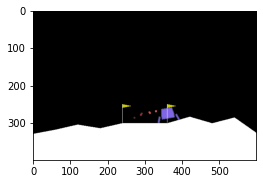

In [ ]:
plt.figure(figsize=(4, 3))
display.clear_output(wait=True)

obs = env.reset()
for t in range(TIME_LIMIT):
    plt.gca().clear()
    
    probs = agent.predict_proba([obs]).reshape(n_actions,)
    action = np.random.choice(np.arange(n_actions), p=probs)
    new_obs, reward, done, _ = env.step(action)
    obs = new_obs

    plt.imshow(env.render('rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

display.clear_output(wait=True)

---

## Solving contituous environments

In [ ]:
# TODO